<center>
<img src="https://cdn.megabonus.com/images/shop_logo/skillbox.png"/> 
    
# Курс аналитик данных на Python
## Модуль 3.1. Pandas advanced. Составляем отчетность.

In [1]:
import numpy as np
import pandas as pd
import random

/var/folders/t1/pt8lfl0s2rz_z_7z9cbm9f5r0000gn/T/ipykernel_89814/1403132920.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Итак, в этом уроке мы попробуем решить совсем прикладную задачу и научимся работать с табличными данными.<br>
А именно:
* узнаем как работать с файлом, который весит **30+ мегабайт**.;
* посчитаем **базовые статистики** в разных **разрезах и сегментах пользователей** и **уберем выбросы**;
* поймем **как объединить таблицы** по ключу;
* оформим **отчет по среднему чеку по дате и в разрезе категорий** и **отчет по оттоку пользователей**;
* сделаем **отдельную функцию для отправления на почту**;
<br>
Но обо всем по порядку!


Для начала прочитаем данные с помощью библиотеки [**pandas**](http://pandas.pydata.org/pandas-docs/stable/).<br>
Наши довольно большие. Таблица более миллиона строк и в распакованном виде весит около **30 мб**<br>
Это не так много, но вопрос сколько времени excel это будет читать оставляю вам на размышление)

## 1. Загрузим наш файл.

In [2]:
data = pd.read_csv('data.csv.gz', compression='gzip')

Как и прежде, первое с чего нужно начать это с того чтобы понять что перел нами за данные.<br>
Посмотрим на количество строк, колонки и типы данных. Также заметим что в распакованном виде наши **данные раздулись до 53+ мб**.

In [3]:
print('У нас %s строк и %s колонок.'%data.shape)
print('---')
print(data.info())

У нас 1008889 строк и 8 колонок.
---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008889 entries, 0 to 1008888
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   mcc           1008889 non-null  int64  
 1   period        1008889 non-null  object 
 2   trdatetime    1008889 non-null  object 
 3   amount        1008889 non-null  float64
 4   channel_type  1003825 non-null  object 
 5   cl_id         1008889 non-null  int64  
 6   currency      1008889 non-null  int64  
 7   trx_category  1008889 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 61.6+ MB
None


In [4]:
data.describe()

,mcc,amount,cl_id,currency
count,1.008889e+06,1.008889e+06,1.008889e+06,1.008889e+06
mean,5.695758e+03,5.613910e+03,4.792338e+03,8.106325e+02
std,6.629852e+02,6.258510e+04,2.956989e+03,3.869616e+01
min,7.420000e+02,1.000000e-02,0.000000e+00,3.200000e+01
25%,5.411000e+03,2.200000e+02,2.184000e+03,8.100000e+02
50%,5.661000e+03,6.162000e+02,4.586000e+03,8.100000e+02
75%,5.941000e+03,2.147000e+03,7.350000e+03,8.100000e+02
max,9.405000e+03,3.583500e+07,1.021600e+04,9.860000e+02


И посмотрим на первые 3 строчки.

In [5]:
data.head(3)

,mcc,period,trdatetime,amount,channel_type,cl_id,currency,trx_category
0,5200,01/10/2017,21OCT17:00:00:00,5023.0,NaN,0,810,POS
1,6011,01/10/2017,12OCT17:12:24:07,20000.0,NaN,0,810,DEPOSIT
2,5921,01/12/2017,05DEC17:00:00:00,767.0,NaN,0,810,POS


Сразу можно заметить, что у нас транзакционный датасет. Так как это реальные данные, то некоторые поля заменяются приватными значения, как например тут категория валюты.<br> 

Мы можем посчитать сколько унас валют всего, чтобы понять масштабы.

In [6]:
len(data['currency'].unique())

67

И посмотреть что у нас за категории. Смутно можно понять, что они связаны с типом транзакции, например <br>
`WD_ATM_PARTNER` это снятие с банкомата партнера, а `POS` это потребительский кредит, тоесть оплата с кредитной карты.

In [7]:
data.trx_category.unique()

array(['POS', 'DEPOSIT', 'C2C_OUT', 'WD_ATM_ROS', 'BACK_TRX',
       'WD_ATM_PARTNER', 'WD_ATM_OTHER', 'C2C_IN', 'CAT', 'CASH_ADV'],
      dtype=object)

In [8]:
data.head()

,mcc,period,trdatetime,amount,channel_type,cl_id,currency,trx_category
0,5200,01/10/2017,21OCT17:00:00:00,5023.0,NaN,0,810,POS
1,6011,01/10/2017,12OCT17:12:24:07,20000.0,NaN,0,810,DEPOSIT
2,5921,01/12/2017,05DEC17:00:00:00,767.0,NaN,0,810,POS
3,5411,01/10/2017,21OCT17:00:00:00,2031.0,NaN,0,810,POS
4,6012,01/10/2017,24OCT17:13:14:24,36562.0,NaN,0,810,C2C_OUT


Сразу бросается в глаза дата транзакции и ее формат, поэтому давайте приведем ее в нормальный вид.<br>
А так же отдельные колонки для года/месяца/дня/времени и соединим месяц с годом, для удобства <br>
(так как у нас данные за несколько лет), чтобы потом сделать помесячные отчеты.<br>
Чтобы не потерять и не испортить данные, лучше делать отдельные колонки.

In [9]:
# преобразование даты
data['period'] = pd.to_datetime(data['period'], format='%d/%m/%Y')

# преобразование времени
data['transac_time'] = data['trdatetime'].str[-11:-3]

# разные компоненты даты по столбцам
data['transac_day'] = data['trdatetime'].str[:2]
month_dict={'JAN':'01', 'FEB':'02', 'MAR':'03', 'APR':'04', 'MAY':'05', 'JUN':'06', 
            'JUL':'07', 'AUG':'08', 'SEP':'09', 'OCT':'10', 'NOV':'11', 'DEC':'12'}
data['transac_month'] = data['trdatetime'].str[2:5].map(month_dict)
data['transac_year'] = '20'+data['trdatetime'].str[5:7]

# комбинированное поле месяц-год
#data['transac_year_month'] = data['period'].apply(lambda x: x.strftime('%m-%Y')) 
data['transac_year_month'] = '20'+data['trdatetime'].str[5:7]+'-'+data['trdatetime'].str[2:5].map(month_dict)

In [10]:
data.head(3)

,mcc,period,trdatetime,amount,channel_type,cl_id,currency,trx_category,transac_time,transac_day,transac_month,transac_year,transac_year_month
0,5200,2017-10-01,21OCT17:00:00:00,5023.0,NaN,0,810,POS,17:00:00,21,10,2017,2017-10
1,6011,2017-10-01,12OCT17:12:24:07,20000.0,NaN,0,810,DEPOSIT,17:12:24,12,10,2017,2017-10
2,5921,2017-12-01,05DEC17:00:00:00,767.0,NaN,0,810,POS,17:00:00,05,12,2017,2017-12


Отлично, давайте теперь посмотрим на экстримальные значения наших транзакций.

In [11]:
(data.groupby('currency')['amount'].agg(['min', 'mean', 'median','max']).tail())

,min,mean,median,max
currency,,,,
978,0.01,105.797974,29.00,9690.00
980,1.50,885.639098,282.00,15451.17
981,0.80,94.718251,35.62,1306.00
985,0.99,101.715674,35.67,4800.00
986,6.00,88.106471,60.00,260.00


Ок, но не ясно что за валюты, может где-то можно найти соотвествие числовых кодов и хотябы привычных<br>
трехбуквенных кодов вида **USD**, **EUR**, **RUB**?

## 2. Расшифруем валютные коды.

In [12]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

# Загрузка страницы
url = 'https://en.wikipedia.org/wiki/ISO_4217#Active_codes_(list_one)'
response = requests.get(url)

# Создание объекта BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')

# Нахождение таблицы
table = soup.find('table', {'class': 'wikitable'})

# Извлечение данных из таблицы
rows = table.find_all('tr')
data_1 = []
for row in rows:
    cols = row.find_all(['th', 'td'])
    cols = [col.text.strip() for col in cols]
    data_1.append(cols)

# Создание DataFrame
wiki_table = pd.DataFrame(data_1[1:], columns=data_1[0])

# Создание CSV
wiki_table.to_csv('currency_codes_wiki.csv')

# Вывод DataFrame
wiki_table

/Users/adil/PycharmProjects/codes/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


ConnectionError: HTTPSConnectionPool(host='en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/ISO_4217 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x17a0b33d0>: Failed to resolve 'en.wikipedia.org' ([Errno 8] nodename nor servname provided, or not known)"))

In [13]:
wiki_table = pd.read_csv('currency_codes_wiki.csv')
wiki_table.head()

,Unnamed: 0,Code,Num,D[a],Currency,Locations listed for this currency[b]
0,0,AED,784,2,United Arab Emirates dirham,United Arab Emirates
1,1,AFN,971,2,Afghan afghani,Afghanistan
2,2,ALL,8,2,Albanian lek,Albania
3,3,AMD,51,2,Armenian dram,Armenia
4,4,ANG,532,2,Netherlands Antillean guilder,"Curaçao (CW), Sint Maarten (SX)"


In [14]:
wiki_table.info()
print(wiki_table)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 6 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Unnamed: 0                             179 non-null    int64 
 1   Code                                   179 non-null    object
 2   Num                                    179 non-null    int64 
 3   D[a]                                   179 non-null    object
 4   Currency                               179 non-null    object
 5   Locations listed for this currency[b]  169 non-null    object
dtypes: int64(2), object(4)
memory usage: 8.5+ KB
     Unnamed: 0 Code  Num D[a]                       Currency  \
0             0  AED  784    2    United Arab Emirates dirham   
1             1  AFN  971    2                 Afghan afghani   
2             2  ALL    8    2                   Albanian lek   
3             3  AMD   51    2                  Ar

In [15]:
data.head()

,mcc,period,trdatetime,amount,channel_type,cl_id,currency,trx_category,transac_time,transac_day,transac_month,transac_year,transac_year_month
0,5200,2017-10-01,21OCT17:00:00:00,5023.0,NaN,0,810,POS,17:00:00,21,10,2017,2017-10
1,6011,2017-10-01,12OCT17:12:24:07,20000.0,NaN,0,810,DEPOSIT,17:12:24,12,10,2017,2017-10
2,5921,2017-12-01,05DEC17:00:00:00,767.0,NaN,0,810,POS,17:00:00,05,12,2017,2017-12
3,5411,2017-10-01,21OCT17:00:00:00,2031.0,NaN,0,810,POS,17:00:00,21,10,2017,2017-10
4,6012,2017-10-01,24OCT17:13:14:24,36562.0,NaN,0,810,C2C_OUT,17:13:14,24,10,2017,2017-10


Переведем наши поля по которым будем мэтчить в один тип данных. Я выбрал `int`.<br>
Приводить значения в таблице `wiki_table` нам не надо так как они уже в `int`.

In [16]:
#wiki_table['num_code'] = wiki_table['num_code'].astype(int)
data['currency'] = data['currency'].astype(int)

Чтобы совместить таблички нам нужно их "смерджить", то есть применить метод **.merge**, который дословно значит "слить".<br>
Итак, смерджить таблички можно по-разному, как схематически показано ниже. И в зависимости от смысла задачи может требоваться <br>
разный вид мерджа. В нашем случае нам нужен левый (left), чтобы притянуть все значения к левой табличке.<br>
Про объединение таблиц и различного рода совмещения очень хорошо написано с примерами в [документации](https://pandas.pydata.org/pandas-docs/stable/merging.html).
<img src="https://shanelynnwebsite-mid9n9g1q9y8tt.netdna-ssl.com/wp-content/uploads/2017/03/join-types-merge-names.jpg"/> 

In [17]:
# data = data.merge(wiki_table, left_on='currency', right_on='Num', how='left').head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008889 entries, 0 to 1008888
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   mcc                 1008889 non-null  int64         
 1   period              1008889 non-null  datetime64[ns]
 2   trdatetime          1008889 non-null  object        
 3   amount              1008889 non-null  float64       
 4   channel_type        1003825 non-null  object        
 5   cl_id               1008889 non-null  int64         
 6   currency            1008889 non-null  int64         
 7   trx_category        1008889 non-null  object        
 8   transac_time        1008889 non-null  object        
 9   transac_day         1008889 non-null  object        
 10  transac_month       1008889 non-null  object        
 11  transac_year        1008889 non-null  object        
 12  transac_year_month  1008889 non-null  object        
dtypes: datetime6

**WAT DA HELL?**

Хух, ну вроде все верно, но что не так?

In [18]:
data['currency'] = data['currency'].astype(int)

# Выполняем объединение с явным указанием суффиксов
merged_data = data.merge(wiki_table, left_on='currency', right_on='Num', how='left', suffixes=('_data', '_wiki'))

# Уникальные значения 'Num' в объединенном DataFrame
unique_nums = merged_data['Num'].unique()

# Выводим уникальные значения
print(unique_nums)

# Обновляем столбец 'Num' в 'data' с уникальными значениями из 'Num_wiki'
data['Num'] = merged_data['Num']

# Выводим обновленные данные в 'data'
print(data.head())

[ nan 978. 504. 704. 981. 985. 840. 949.  51. 826. 214. 764. 203. 702.
 360. 756. 933. 975.  36. 784. 980. 124. 398. 376. 944. 352. 417. 156.
 752. 392. 484. 634. 188. 643. 348. 356. 458. 986. 498. 578. 208. 344.
  32. 410. 788. 480. 604. 941. 144. 946. 710. 690.  44. 170. 901. 608.
 554. 462. 800. 977. 496. 516.  48. 446. 404. 524.]
    mcc     period        trdatetime   amount channel_type  cl_id  currency  \
0  5200 2017-10-01  21OCT17:00:00:00   5023.0          NaN      0       810   
1  6011 2017-10-01  12OCT17:12:24:07  20000.0          NaN      0       810   
2  5921 2017-12-01  05DEC17:00:00:00    767.0          NaN      0       810   
3  5411 2017-10-01  21OCT17:00:00:00   2031.0          NaN      0       810   
4  6012 2017-10-01  24OCT17:13:14:24  36562.0          NaN      0       810   

  trx_category transac_time transac_day transac_month transac_year  \
0          POS     17:00:00          21            10         2017   
1      DEPOSIT     17:12:24          12          

Дело в том, что в российских банках транзакции учитываюсь с кодом 810, который был введен **еще до деноминации 1998 года.** <br>
<center>
<img src="https://cs5.pikabu.ru/post_img/2015/12/04/5/1449210847155432089.jpg"/> 
    
А в международном стандарте у России код: 643, что мы и можем видеть в таблице ниже.<br>
Внутренний код для платежей в рублях до сих пор 810, что немного смущет, если честно.<br>
Вокруг этого ходит довольно много баек и мифов, но с другой стороны, по сути это всего лишь дирекция ЦБ России <br>
и присутствие того или иного кода в платежке ни на что не влияет существенным образом.<br>
Тем не менее, кому интересно, больше можно почитать [тут](https://goo.gl/Jb5rQG) и конкретно [тут](https://fincult.info/articles/valyuty/mify-i-pravda-o-valyutnykh-kodakh-rublya/).<br>
Но вернемся к делу!

In [19]:
wiki_table[wiki_table['Currency'] == 'Russian ruble']

,Unnamed: 0,Code,Num,D[a],Currency,Locations listed for this currency[b]
118,118,RUB,643,2,Russian ruble,Russia


In [20]:
wiki_table[wiki_table['Currency'].isin(["United States dollar","Afghan afghani"])]

,Unnamed: 0,Code,Num,D[a],Currency,Locations listed for this currency[b]
1,1,AFN,971,2,Afghan afghani,Afghanistan
147,147,USD,840,2,United States dollar,"United States, American Samoa (AS), British ..."


Поправим немного нашу таблицу, чтобы мы могли классифицировать наши транзакции полностью.

In [21]:
import pandas as pd

# Ваш DataFrame 'wiki_table'
data_2 = {'Num': [810], 'Code': ['RUR'], 'Currency': ['Russian ruble']}
new_row = pd.DataFrame(data_2)

# Обновление значения в 'Locations listed for this currency[b]' для кода 'RUR'
wiki_table.loc[wiki_table['Code'] == 'RUR', 'Locations listed for this currency[b]'] = 'Russia'

# Добавление новой строки в DataFrame 'wiki_table'
wiki_table = pd.concat([wiki_table, new_row], ignore_index=True)

# Вывод DataFrame после изменений
print(wiki_table)


     Unnamed: 0 Code  Num D[a]                       Currency  \
0           0.0  AED  784    2    United Arab Emirates dirham   
1           1.0  AFN  971    2                 Afghan afghani   
2           2.0  ALL    8    2                   Albanian lek   
3           3.0  AMD   51    2                  Armenian dram   
4           4.0  ANG  532    2  Netherlands Antillean guilder   
..          ...  ...  ...  ...                            ...   
175       175.0  YER  886    2                    Yemeni rial   
176       176.0  ZAR  710    2             South African rand   
177       177.0  ZMW  967    2                 Zambian kwacha   
178       178.0  ZWL  932    2   Zimbabwean dollar (fifth)[g]   
179         NaN  RUR  810  NaN                  Russian ruble   

           Locations listed for this currency[b]  
0                           United Arab Emirates  
1                                    Afghanistan  
2                                        Albania  
3              

В этот раз сохраним наши измениея, переназначив объект.

In [22]:
data = data.merge(wiki_table, left_on='currency', right_on='Num', how='left')
data.head()

,mcc,period,trdatetime,amount,channel_type,cl_id,currency,trx_category,transac_time,transac_day,transac_month,transac_year,transac_year_month,Num_x,Unnamed: 0,Code,Num_y,D[a],Currency,Locations listed for this currency[b]
0,5200,2017-10-01,21OCT17:00:00:00,5023.0,NaN,0,810,POS,17:00:00,21,10,2017,2017-10,NaN,NaN,RUR,810.0,NaN,Russian ruble,NaN
1,6011,2017-10-01,12OCT17:12:24:07,20000.0,NaN,0,810,DEPOSIT,17:12:24,12,10,2017,2017-10,NaN,NaN,RUR,810.0,NaN,Russian ruble,NaN
2,5921,2017-12-01,05DEC17:00:00:00,767.0,NaN,0,810,POS,17:00:00,05,12,2017,2017-12,NaN,NaN,RUR,810.0,NaN,Russian ruble,NaN
3,5411,2017-10-01,21OCT17:00:00:00,2031.0,NaN,0,810,POS,17:00:00,21,10,2017,2017-10,NaN,NaN,RUR,810.0,NaN,Russian ruble,NaN
4,6012,2017-10-01,24OCT17:13:14:24,36562.0,NaN,0,810,C2C_OUT,17:13:14,24,10,2017,2017-10,NaN,NaN,RUR,810.0,NaN,Russian ruble,NaN


Вот теперь совсем все хорошо и у нас все транзакции размечены нормальными названиями валют в которых они были совершены.
Напомню, что числовы коды у нас типа `int`.

In [25]:
data[data['currency'] == 810].head()

,mcc,period,trdatetime,amount,channel_type,cl_id,currency,trx_category,transac_time,transac_day,transac_month,transac_year,transac_year_month,Num_x,Unnamed: 0,Code,Num_y,D[a],Currency,Locations listed for this currency[b]
0,5200,2017-10-01,21OCT17:00:00:00,5023.0,NaN,0,810,POS,17:00:00,21,10,2017,2017-10,NaN,NaN,RUR,810.0,NaN,Russian ruble,NaN
1,6011,2017-10-01,12OCT17:12:24:07,20000.0,NaN,0,810,DEPOSIT,17:12:24,12,10,2017,2017-10,NaN,NaN,RUR,810.0,NaN,Russian ruble,NaN
2,5921,2017-12-01,05DEC17:00:00:00,767.0,NaN,0,810,POS,17:00:00,05,12,2017,2017-12,NaN,NaN,RUR,810.0,NaN,Russian ruble,NaN
3,5411,2017-10-01,21OCT17:00:00:00,2031.0,NaN,0,810,POS,17:00:00,21,10,2017,2017-10,NaN,NaN,RUR,810.0,NaN,Russian ruble,NaN
4,6012,2017-10-01,24OCT17:13:14:24,36562.0,NaN,0,810,C2C_OUT,17:13:14,24,10,2017,2017-10,NaN,NaN,RUR,810.0,NaN,Russian ruble,NaN


Пропусков нет! Мы разметили все транзакции.

In [26]:
data['currency'].isna().value_counts()

currency
False    1008889
Name: count, dtype: int64

Вернемся к нашей сгруппированной табличке.

In [27]:
data.groupby('currency')['amount'].agg(['min', 'mean', 'median','max']).tail()

,min,mean,median,max
currency,,,,
978,0.01,105.797974,29.00,9690.00
980,1.50,885.639098,282.00,15451.17
981,0.80,94.718251,35.62,1306.00
985,0.99,101.715674,35.67,4800.00
986,6.00,88.106471,60.00,260.00


И сделаем её немного читабельнее.<br>
Стоит заметить, что сортировка происходит по индексу, так что в случае с числовым кодом и названием валюты у нас <br>
будет разный порядок.

In [28]:
data.groupby('currency')['amount'].agg(['min', 'mean', 'median','max']).tail().apply(lambda x:round(x,0))

,min,mean,median,max
currency,,,,
978,0.0,106.0,29.0,9690.0
980,2.0,886.0,282.0,15451.0
981,1.0,95.0,36.0,1306.0
985,1.0,102.0,36.0,4800.0
986,6.0,88.0,60.0,260.0


In [29]:
data[(data['currency'].isin([840,978]))].groupby('Currency')["amount"].mean()


Currency
Euro                    105.797974
United States dollar    173.517300
Name: amount, dtype: float64

## 3. Расшифруем MCC коды.

Также в интренете можно найти информаци о [MCC](https://en.wikipedia.org/wiki/Merchant_category_code). Это стандартизированный код категории покупки, который устанавливается на кассы предприятия. Потом банки исходя из этих кодов могут начислять кэшбек или бонусы за проведенные транзакции, если это предуматривает Ваш тариф. Имея текстовые репрезентации этих кодов довольно сильно поможет нам при построении осмысленного отчета.<br>

У нас есть табличка с различными mcc кодами и их интерпритацией, которую я просто нагуглил.

In [30]:
mcc = pd.read_excel('mcc_codes.xls')

In [31]:
mcc.head()

,STANDARD MERCHANT CATEGORY CODES\n**Please do not sort this spreadsheet**,Unnamed: 1,Unnamed: 2
0,MCC CODE,Program Type:,NaN
1,0742,Veterinary Services,NaN
2,0763,Agricultural Cooperatives,NaN
3,0780,Landscaping and Horticultural Services,NaN
4,1520,General Contractor/Residential Building,NaN


Очень часто бывае что эксель попадает в таком виде. Чтобы получить красивую табличку нужно пропустить первый ряд и убрать правую колонку с пустыми значениями. Так и сделаем:

In [32]:
mcc = pd.read_excel('mcc_codes.xls',skiprows=1)
mcc = mcc.iloc[:,:-1]
mcc.head()

,MCC CODE,Program Type:
0,742.0,Veterinary Services
1,763.0,Agricultural Cooperatives
2,780.0,Landscaping and Horticultural Services
3,1520.0,General Contractor/Residential Building
4,1711.0,"Heating, Plumbing, Air Conditioning Contractors"


И переименуем колонки для красоты и удобства.

In [33]:
mcc = mcc.rename(columns={'MCC CODE':'mcc','Program Type:':'category'})

In [34]:
mcc.head()

,mcc,category
0,742.0,Veterinary Services
1,763.0,Agricultural Cooperatives
2,780.0,Landscaping and Horticultural Services
3,1520.0,General Contractor/Residential Building
4,1711.0,"Heating, Plumbing, Air Conditioning Contractors"


Объедним по категории к нашей общей таблице (левый мердж). <br>

In [35]:
data = data.merge(mcc, on='mcc', how='left')

In [36]:
data.head()

,mcc,period,trdatetime,amount,channel_type,cl_id,currency,trx_category,transac_time,transac_day,...,transac_year,transac_year_month,Num_x,Unnamed: 0,Code,Num_y,D[a],Currency,Locations listed for this currency[b],category
0,5200,2017-10-01,21OCT17:00:00:00,5023.0,NaN,0,810,POS,17:00:00,21,...,2017,2017-10,NaN,NaN,RUR,810.0,NaN,Russian ruble,NaN,Home Supply Warehouse
1,6011,2017-10-01,12OCT17:12:24:07,20000.0,NaN,0,810,DEPOSIT,17:12:24,12,...,2017,2017-10,NaN,NaN,RUR,810.0,NaN,Russian ruble,NaN,Financial Institutions--Automated Cash Disburs...
2,5921,2017-12-01,05DEC17:00:00:00,767.0,NaN,0,810,POS,17:00:00,05,...,2017,2017-12,NaN,NaN,RUR,810.0,NaN,Russian ruble,NaN,"Package Stores--Beer, Wine, and Liquor"
3,5411,2017-10-01,21OCT17:00:00:00,2031.0,NaN,0,810,POS,17:00:00,21,...,2017,2017-10,NaN,NaN,RUR,810.0,NaN,Russian ruble,NaN,Grocery Stores and Supermarkets
4,6012,2017-10-01,24OCT17:13:14:24,36562.0,NaN,0,810,C2C_OUT,17:13:14,24,...,2017,2017-10,NaN,NaN,RUR,810.0,NaN,Russian ruble,NaN,Quasi Cash - Financial Institution - Merchandi...


Проверим сколько у нас категорий не подтянулось с помощью методов **.isna()** и **.value_counts()**.

In [37]:
data.category.isna().value_counts()

category
False    1008888
True           1
Name: count, dtype: int64

In [38]:
data.mcc.isna().value_counts()

mcc
False    1008889
Name: count, dtype: int64

In [39]:
data.to_csv('data.csv', index=False)

Действительно, в силу тех или иных причин мы не смогли индифицировать всего лишь 1 код, так что мы можем этим пренебречь.

## 4.  Отчет по средним тратам.

Давайте уже построим отчет! Для этих целей отберем только рублевые транзакции и сделаем табличку в разрезе категория-даты.<br>

Также, тк природа данных это покупки/транзакции, то присутствуют экстримальные значения, которые будут искажать среднее по больнице.
Поэтому мы **отбросим по 5% максимальных значений и столько же минимальных**. Это называется **очисткой от выбросов** и для этого нам понадобится посчитать квартили и применить фильтрацию.

In [40]:
report = pd.DataFrame()
currency = 810
rubbles = data[data['currency'] == currency]
dates = sorted(rubbles['transac_year_month'].unique())


for date in dates:
    buffer = rubbles[rubbles['transac_year_month'] == date][['transac_year_month','amount','category']].set_index(['transac_year_month','category'])

    low = .05
    high = .95
    quant_df = buffer.quantile([low, high])

    filtered_df = buffer.apply(lambda x: x[(x>quant_df.loc[low,x.name]) & (x < quant_df.loc[high,x.name])], axis=0)
    filtered_df = filtered_df.reset_index().groupby(['transac_year_month','category']).mean()

    report = pd.concat([report, filtered_df]) # объединяем нашу таблицу

report = report.unstack().T # разворачиваем нашу таблицу 
report = round(report,2)

In [41]:
report.head()

transac_year_month                                       2016-10   2016-11  \
       category                                                              
amount AIR STANA                                             NaN       NaN   
       Accounting, Auditing, and Bookkeeping Services        NaN   2294.42   
       Advertising Services                              1306.57   2674.30   
       AeroFlot                                         20423.09  12961.51   
       Agricultural Cooperatives                             NaN       NaN   

transac_year_month                                       2016-12   2017-01  \
       category                                                              
amount AIR STANA                                             NaN  14061.00   
       Accounting, Auditing, and Bookkeeping Services        NaN    960.00   
       Advertising Services                              1863.58   1367.67   
       AeroFlot                                         13992.32   8480.99   
       Agricultural Cooperatives                             NaN    702.00   

transac_year_month                                       2017-02   2017-03  \
       category                                                              
amount AIR STANA                                        10977.00       NaN   
       Accounting, Auditing, and Bookkeeping Services        NaN       NaN   
       Advertising Services                              1071.13   1117.51   
       AeroFlot                                          9766.56  11490.96   
       Agricultural Cooperatives                          624.00       NaN   

transac_year_month                                      2017-04  2017-05  \
       category                                                            
amount AIR STANA                                            NaN      NaN   
       Accounting, Auditing, and Bookkeeping Services       NaN   290.00   
       Advertising Services                             1783.02  1130.19   
       AeroFlot                                         9601.84  8756.14   
       Agricultural Cooperatives                        1879.50  1440.00   

transac_year_month                                       2017-06   2017-07  \
       category                                                              
amount AIR STANA                                        14092.00  11113.67   
       Accounting, Auditing, and Bookkeeping Services        NaN       NaN   
       Advertising Services                              1490.12   2049.76   
       AeroFlot                                         10632.52   9061.11   
       Agricultural Cooperatives                         1531.50       NaN   

transac_year_month                                       2017-08  2017-09  \
       category                                                             
amount AIR STANA                                        10691.00      NaN   
       Accounting, Auditing, and Bookkeeping Services        NaN   720.00   
       Advertising Services                              1517.03  1700.32   
       AeroFlot                                         10445.11  9230.78   
       Agricultural Cooperatives                             NaN   174.00   

transac_year_month                                      2017-10   2017-11  \
       category                                                             
amount AIR STANA                                            NaN       NaN   
       Accounting, Auditing, and Bookkeeping Services       NaN       NaN   
       Advertising Services                             2955.57    533.81   
       AeroFlot                                         9766.24  16065.27   
       Agricultural Cooperatives                            NaN       NaN   

transac_year_month                                       2017-12   2018-01  \
       category                                                              
amount AIR STANA                           

In [42]:
def do_report(dataframe, currency_int):
    """
    Данная функция делает отчет по аналогии с тем что мыы делали выше, но принимает на вход таблицу и значение валюты
    по которым нужно построить отчет.
    
    Сначала мы создаем пустую таблицу в которую будем добавлять уже посчитанные значения.
    Далее создаем срез из переданной таблицы и создаем отсортированный вектор дат.
    
    После этого начинается цикл, которй бегает по сформированному срезу и берет транзакции по определенной дате и 
    выбирает значения ['transac_year_month','amount','category'].
    
    Далее рассчитаывается .05 и .95 квартиль распределения. По сути мы отбрасываем по 5% максимальных значений и 
    столько же минимальных, тем самым очищая от выбросов, которые могут исказить наши средние значения.
    После того как рассчитали пороги, мы приминяем фильтрацию и получаем очищенную табличку.
    
    Присоединяем ее к созданной в начале с помощью метода pd.concat, разворачиваем и транспонируем.

    """
    
    report = pd.DataFrame()
    currency = currency_int
    df = dataframe[dataframe['currency'] == currency]
    dates = sorted(df['transac_year_month'].unique())


    for date in dates:
        buffer = df[df['transac_year_month'] == date][['transac_year_month','amount','category']].set_index(['transac_year_month','category'])

        # посчитаем значения квартилей по которым будем обрезать наши значния в транзакциях
        low = .05
        high = .95
        quant_df = buffer.quantile([low, high])

        # отфильтруем значения 
        filtered_df = buffer.apply(lambda x: x[(x>quant_df.loc[low,x.name]) & (x < quant_df.loc[high,x.name])], axis=0)
        filtered_df = filtered_df.reset_index().groupby(['transac_year_month','category']).mean()

        # объединяем нашу посчитанную таблицу с главной
        report = pd.concat([report, filtered_df])

    # разворачиваем нашу таблицу, транспонируем и удаляем одну колонку по которой индексировались - непростое комбо!
    report = report.unstack().T
    
    """
    P.S. Пофиксили случай, когда у нас получается слишком маленький отчет и наше отсечение порогов захватывает все записи и у нас
    остается пустой отчет, который приводит к ошибке в следующей функции, которая записывает отчет в excel.
    Я решил написать просто дополнение, а не переписывать функцию полностью.
    """
    if report.shape[0] == 0: # сравниваем длину нашего отчета с нулем. если да, то делаем операции внутри цикла.
        
        report = pd.DataFrame() # обнуляем наш отчет
        
        # для каждой из дат считаем все теже операции, что и выше, но без отсечения выбросов.
        for date in dates:
            buffer = df[df['transac_year_month'] == date][['transac_year_month','amount','category']].set_index(['transac_year_month','category'])
            buffer = buffer.groupby(['transac_year_month','category']).mean()
            report = pd.concat([report, buffer])
            return round(report,2) # возвращаем таблицу с округленными значениями
    else:
        return round(report,2)

In [43]:
rep = do_report(data,810)
rep

transac_year_month                                       2016-10   2016-11  \
       category                                                              
amount AIR STANA                                             NaN       NaN   
       Accounting, Auditing, and Bookkeeping Services        NaN   2294.42   
       Advertising Services                              1306.57   2674.30   
       AeroFlot                                         20423.09  12961.51   
       Agricultural Cooperatives                             NaN       NaN   
...                                                          ...       ...   
       Watch, Clock, and Jewelry Repair Shops                NaN       NaN   
       Wholesale Club with or without membership fee    12276.22   6662.86   
       Wig & Toupee Shops                                    NaN       NaN   
       Women's Accessory and Specialty Stores            1228.40   2127.35   
       Women's Ready-to-Wear Stores                      8233.03   6074.67   

transac_year_month                                       2016-12   2017-01  \
       category                                                              
amount AIR STANA                                             NaN  14061.00   
       Accounting, Auditing, and Bookkeeping Services        NaN    960.00   
       Advertising Services                              1863.58   1367.67   
       AeroFlot                                         13992.32   8480.99   
       Agricultural Cooperatives                             NaN    702.00   
...                                                          ...       ...   
       Watch, Clock, and Jewelry Repair Shops                NaN       NaN   
       Wholesale Club with or without membership fee     4101.72   3943.72   
       Wig & Toupee Shops                                    NaN   2000.00   
       Women's Accessory and Specialty Stores            2307.11   2518.97   
       Women's Ready-to-Wear Stores                      4550.76   3579.52   

transac_year_month                                       2017-02   2017-03  \
       category                                                              
amount AIR STANA                                        10977.00       NaN   
       Accounting, Auditing, and Bookkeeping Services        NaN       NaN   
       Advertising Services                              1071.13   1117.51   
       AeroFlot                                          9766.56  11490.96   
       Agricultural Cooperatives                          624.00       NaN   
...                                                          ...       ...   
       Watch, Clock, and Jewelry Repair Shops                NaN       NaN   
       Wholesale Club with or without membership fee     3913.00   3178.16   
       Wig & Toupee Shops                                    NaN       NaN   
       Women's Accessory and Specialty Stores            1885.26   2966.96   
       Women's Ready-to-Wear Stores                      4765.81   5491.56   

transac_year_month                                      2017-04  2017-05  \
       category                                                            
amount AIR STANA                                            NaN      NaN   
       Accounting, Auditing, and Bookkeeping Services       NaN   290.00   
       Advertising Services                             1783.02  1130.19   
       AeroFlot                                         9601.84  8756.14   
       Agricultural Cooperatives                        1879.50  1440.00   
...                                                         ...      ...   
       Watch, Clock, and Jewelry Repair Shops               NaN      NaN   
       Wholesale Club with or without membership fee    3814.22  3966.04   
       Wig & Toupee Shops                                   NaN      NaN   
       Women's Accessory and Specialty Stores           3505.10  2999.78   
       Women's Ready-to-Wear Stores        

Проверим. Работает!

Осталось только проделать это все для каждой категории транзакций, записать на отдельный лист и записать в эксельник.<br>
Ниже я написал функуцию, которая циклично добавляет табличку на новыый лист с названием этой таблицы.

In [44]:
import pandas as pd
import openpyxl

def write_excel_cyclicaly(dataframe, dataframe_name, book):
    """
    Эта функция циклично добавляет табличку на новый лист с названием этой таблицы.
    """
    # Если лист с именем dataframe_name уже существует, удаляем его
    if dataframe_name in book.sheetnames:
        idx = book.sheetnames.index(dataframe_name)
        book.remove(book.worksheets[idx])

    # Добавляем новый лист
    sheet = book.create_sheet(title=dataframe_name, index=0)

    # Записываем DataFrame в Excel
    dataframe.to_excel('report1.xlsx', sheet_name=dataframe_name, index=False)

    # Устанавливаем новый лист активным
    book.active = sheet

# определяем транзакционные категории конкретно для выбранного нами кода валюты
trx_cats = data[data['currency'] == 810]['trx_category'].unique()

# создаем/инициализируем файл 
filepath = "report1.xlsx"
book = openpyxl.Workbook()

# добавляем хотя бы один лист (вы можете изменить Sheet1 на другое имя листа)
book.create_sheet("Sheet1", 0)

# сохраняем файл
book.save(filepath)

# цикл создания отчетов и записи в эксель файл
for trx_cat in trx_cats:
    report = do_report(data[data['trx_category'] == trx_cat], 810)
    write_excel_cyclicaly(report, '{}'.format(trx_cat), book)


 Осталось немного. А именно нам нужно создать/инициализировать пустой файл эксель отчета и произвести в него запись,<br>
получившихся таблиц.

In [45]:
rep = do_report(data, 840)

In [46]:
import pandas as pd
import openpyxl

def write_excel_cyclicaly(dataframe, dataframe_name, book):
    """
    Эта функция циклично добавляет табличку на новый лист с названием этой таблицы.
    """
    # Если лист с именем dataframe_name уже существует, удаляем его
    if dataframe_name in book.sheetnames:
        idx = book.sheetnames.index(dataframe_name)
        book.remove(book.worksheets[idx])

    # Добавляем новый лист
    sheet = book.create_sheet(title=dataframe_name, index=0)

    # Записываем DataFrame в Excel
    dataframe.to_excel('report0.xlsx', sheet_name=dataframe_name, index=False)

    # Устанавливаем новый лист активным
    book.active = sheet

# определяем транзакционные категории конкретно для выбранного нами кода валюты
trx_cats = data[data['currency'] == 840]['trx_category'].unique()

# создаем/инициализируем файл 
filepath = "report0.xlsx"
book = openpyxl.Workbook()

# добавляем хотя бы один лист (вы можете изменить Sheet1 на другое имя листа)
book.create_sheet("Sheet1", 0)

# сохраняем файл
book.save(filepath)

# цикл создания отчетов и записи в эксель файл
for trx_cat in trx_cats:
    report = do_report(data[data['trx_category'] == trx_cat], 840)
    write_excel_cyclicaly(report, '{}'.format(trx_cat), book)


In [47]:
rep = do_report(data, 978)

In [48]:
import pandas as pd
import openpyxl

def write_excel_cyclicaly(dataframe, dataframe_name, book):
    """
    Эта функция циклично добавляет табличку на новый лист с названием этой таблицы.
    """
    # Если лист с именем dataframe_name уже существует, удаляем его
    if dataframe_name in book.sheetnames:
        idx = book.sheetnames.index(dataframe_name)
        book.remove(book.worksheets[idx])

    # Добавляем новый лист
    sheet = book.create_sheet(title=dataframe_name, index=0)

    # Записываем DataFrame в Excel
    dataframe.to_excel('report2.xlsx', sheet_name=dataframe_name, index=False)

    # Устанавливаем новый лист активным
    book.active = sheet

# определяем транзакционные категории конкретно для выбранного нами кода валюты
trx_cats = data[data['currency'] == 978]['trx_category'].unique()

# создаем/инициализируем файл 
filepath = "report2.xlsx"
book = openpyxl.Workbook()

# добавляем хотя бы один лист (вы можете изменить Sheet1 на другое имя листа)
book.create_sheet("Sheet1", 0)

# сохраняем файл
book.save(filepath)

# цикл создания отчетов и записи в эксель файл
for trx_cat in trx_cats:
    report = do_report(data[data['trx_category'] == trx_cat], 978)
    write_excel_cyclicaly(report, '{}'.format(trx_cat), book)


## 5. Отчет по оттоку.

Отток, или **churn** можно определять по-разному, например в зависимости от периода.<br>
Так же понятие оттока довольно тесно связано с удержанием или **retention**. Это напротив, сколько людей у нас остается на протяжении из месяца в месяц работы сервиса/подписки и приносит деньги.
Давайте посчитаем классический месячныый отток, тоесть проверим сколько людей уходили в текущий месяц, сравнивая его с предыдущим.

In [49]:
data.head(3)

,mcc,period,trdatetime,amount,channel_type,cl_id,currency,trx_category,transac_time,transac_day,...,transac_year,transac_year_month,Num_x,Unnamed: 0,Code,Num_y,D[a],Currency,Locations listed for this currency[b],category
0,5200,2017-10-01,21OCT17:00:00:00,5023.0,NaN,0,810,POS,17:00:00,21,...,2017,2017-10,NaN,NaN,RUR,810.0,NaN,Russian ruble,NaN,Home Supply Warehouse
1,6011,2017-10-01,12OCT17:12:24:07,20000.0,NaN,0,810,DEPOSIT,17:12:24,12,...,2017,2017-10,NaN,NaN,RUR,810.0,NaN,Russian ruble,NaN,Financial Institutions--Automated Cash Disburs...
2,5921,2017-12-01,05DEC17:00:00:00,767.0,NaN,0,810,POS,17:00:00,05,...,2017,2017-12,NaN,NaN,RUR,810.0,NaN,Russian ruble,NaN,"Package Stores--Beer, Wine, and Liquor"


In [50]:
"""
В этом куске кода мы будем искать оттекших пользователей тоесть cl_id, которых нет в этом месяце, но есть в прошлом. 
С точки зрения банковской деятельности это вобщем-то обосновано и у нас как раз транзакционные данные. В случае если 
это какой-то продукт, то возможно стоит увеличить окно в зависимости от бизнес процессов.

`del previous, current` - Строчка которая, удаляет вектора 
Если вылезла ошибка, то нужно просто закомментировать, а потом раскомментировать, чтобы первая ячейка была всегда np.nan, 
потому что мы считаем отношение к прошлом месяцу, данными к которым мы еще не обладаем.

1) Используем цикл с возможностью отловить ошибку: try ... except, который позволит нам не завершать цикл если вылезет ошибка.
А ошибка у нас вылезает в случае, если у нас нет значения за прошлый период. 
2) Находим вектор айдишников пользователей в текущем месяце.
3) Находим пересечение с прошлым месяцем, точнее инфертированное пересечение или те значения, которых нет в текущем месяце, 
сравнивая с предыдущим. У нас возвращается вектор True/False значений.
P.S. На этом этапе у нас появляется ошибка в когда мы сравниваем первый месяц с прыдыдущего, которого у нас нет. У нас возникает
ошибка, которую мы отлавливает и исполняем код в после except.
4) Мы индексируемся, используя вектор True/False значений, получая только значения айдишников пользователей.
5) Считаем длину вектора или по-другому количество "оттекших" пользователей.
6) Переназначаем текущий вектор айдишников на прошлый период, чтобы сравнивать уже со следующим периодом.

"""

# del previous, current 
churn_array = []

for month in sorted(data['transac_year_month'].unique()):
    # 1
    try:
        # 2
        current = data[data['transac_year_month'] == month]['cl_id'].unique()
        # 3
        churned_idx = np.isin(previous, current, invert=True) 
        # 4
        churned = previous[churned_idx] 
        # 5
        churn_array.append(len(churned))
        # 6
        previous = current
    except NameError:
        churn_array.append(np.nan)
        # 7
        previous = data[data['transac_year_month'] == month]['cl_id'].unique()

In [53]:
churn_table = pd.DataFrame({'months':sorted(data['transac_year_month'].unique()),
                            'churn':churn_array
                           }, columns=['months','churn'])

churn_table

,months,churn
0,2016-10,50
1,2016-11,21
2,2016-12,107
3,2017-01,313
4,2017-02,919
5,2017-03,1220
6,2017-04,1155
7,2017-05,595
8,2017-06,841
9,2017-07,946


In [52]:
# del previous, current 
churn_array = []
retention_array = []

for month in sorted(data['transac_year_month'].unique()):
    # 1
    try:
        # 2
        current = data[data['transac_year_month'] == month]['cl_id'].unique()
        # 3
        retained_idx = np.isin(previous, current)
        # 4
        retained = previous[retained_idx]
        # 5
        retention_array.append(len(retained))
        # 6
        churned_idx = np.isin(previous, current, invert=True) 
        churned = previous[churned_idx]
        # 7
        churn_array.append(len(churned))
        # 8
        previous = current
    except NameError:
        retention_array.append(np.nan)
        churn_array.append(np.nan)
        # 9
        previous = data[data['transac_year_month'] == month]['cl_id'].unique()

result_table = pd.DataFrame({'months': sorted(data['transac_year_month'].unique()),
                              'churn': churn_array,
                              'retention': retention_array
                             }, columns=['months', 'churn', 'retention'])

result_table


,months,churn,retention
0,2016-10,50,0
1,2016-11,21,430
2,2016-12,107,1569
3,2017-01,313,2913
4,2017-02,919,2330
5,2017-03,1220,1992
6,2017-04,1155,1796
7,2017-05,595,2291
8,2017-06,841,2451
9,2017-07,946,2628


In [54]:
result_table.to_csv('retention.csv',index=False)

Запишем наш файл.

In [55]:
churn_table.to_csv('churn.csv',index=False)

Построим минимальный график, чтобы немного затронуть нашу следующую тему- визуализацию.

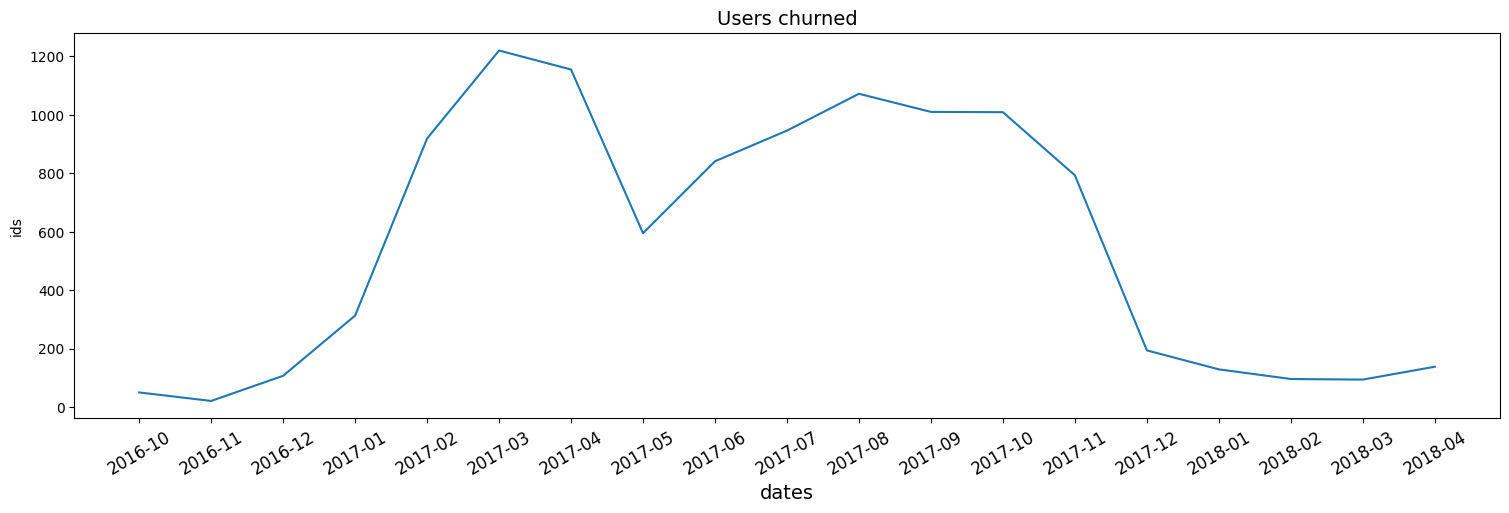

In [56]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(15,5))
churn_table['churn'].plot()

plt.xlabel('dates', fontsize=14)
ax = plt.gca()
plt.xticks(np.arange(0, len(dates), 1.0))
ax.set_xticklabels(churn_table['months'], fontsize=12, rotation=30)
plt.tight_layout()

plt.ylabel('ids')
plt.xlabel('dates')
plt.title('Users churned', fontsize=14)
plt.savefig('churn.png', dpi=300, bbox_inches='tight')
plt.show()

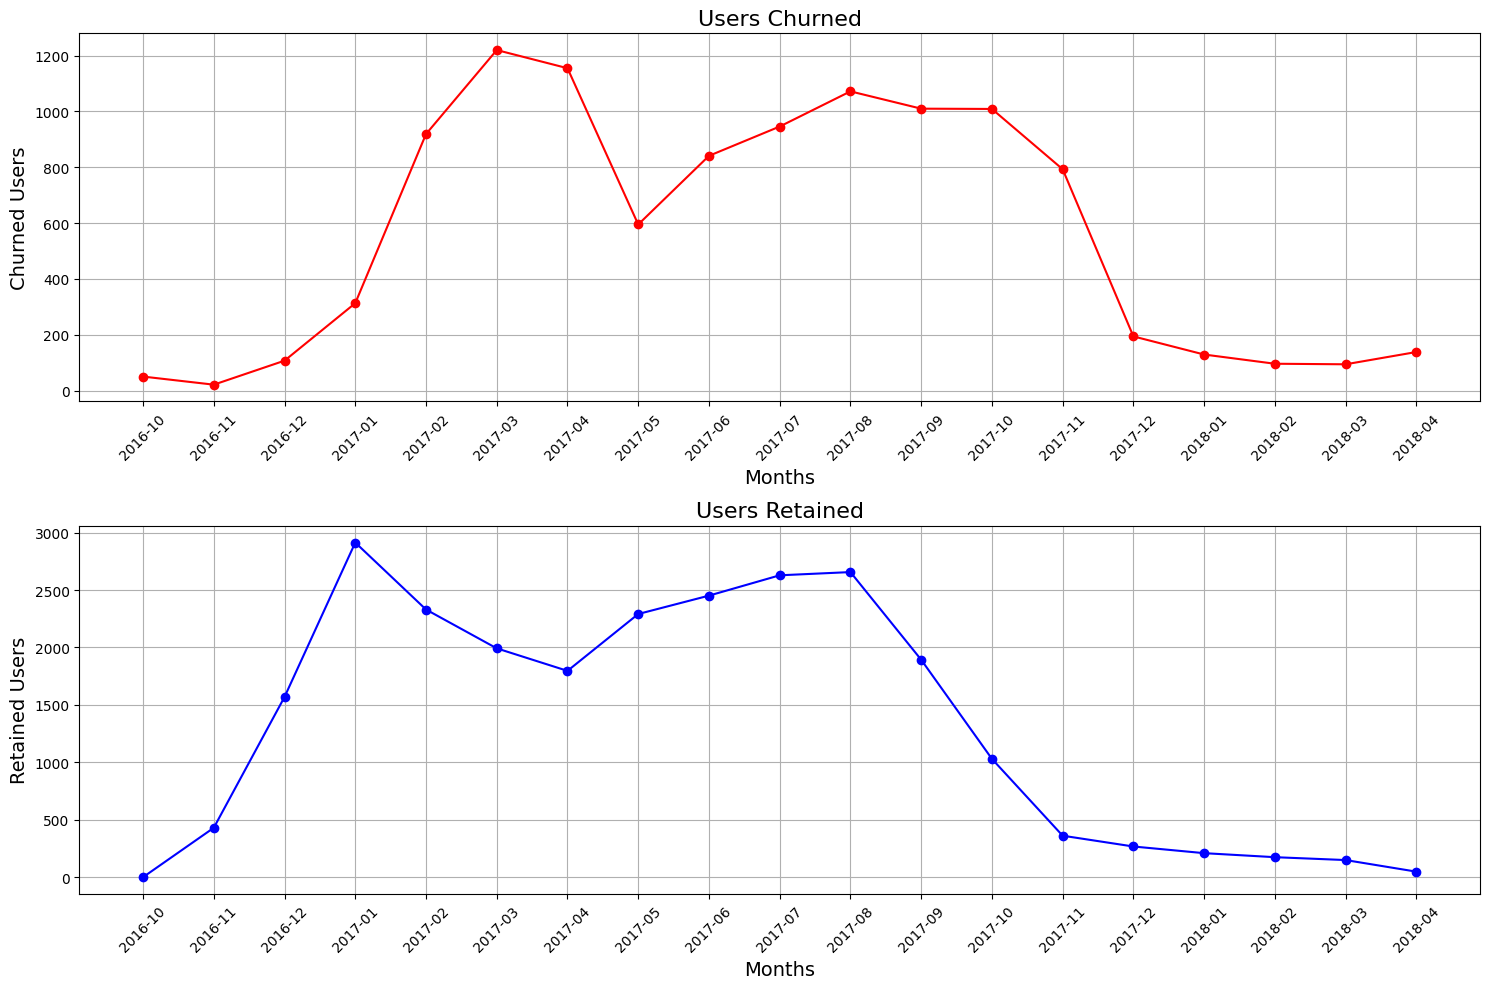

In [57]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,10))

# График для оттока
ax1.plot(churn_table['months'], churn_table['churn'], marker='o', linestyle='-', color='r')
ax1.set_xlabel('Months', fontsize=14)
ax1.set_ylabel('Churned Users', fontsize=14)
ax1.set_title('Users Churned', fontsize=16)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True)

# График для удержания
ax2.plot(result_table['months'], result_table['retention'], marker='o', linestyle='-', color='b')
ax2.set_xlabel('Months', fontsize=14)
ax2.set_ylabel('Retained Users', fontsize=14)
ax2.set_title('Users Retained', fontsize=16)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True)

plt.tight_layout()
plt.savefig('churn_retention.png', dpi=300, bbox_inches='tight')
plt.show()


## 6. Посылаем файлы на почту.

Эта монстр функция посылает прогноз по почте указаным адресам.<br>
Не обязатально понимать сразу все что написано внутри, можно разобрать это по-тихоньку по этапам.

In [58]:
def send_email(mail_from, password, subject):  
    """
    Эта функция посылает файл/файлы по почте указанным адресам.
    
    1) Константы и переменные, которые остаются неизменными, либо меняются нечасто.
    2) Параметры для письма.
    3) Список всех путей до документов, которые нужно послать.
    4) Цикл для присоединения документов к письму.
    5) Цикл для посылки письма. Тестирует на соединение и посылает письмо.
    
    """
    import smtplib, os, sys
    from email.mime.multipart import MIMEMultipart
    from email.mime.text import MIMEText
    from email.mime.base import MIMEBase
    from email import encoders
    
    # 1
    RESULTS_PATH = ''
    SENDER = '4adil4@mail.ru'  
    PASSWORD = 'cvbnjkl123'  
    RECEPIENTS = 'lida2004adil@gmail.com'  
    COMMASPACE = ', '
    
    # 2
    outer = MIMEMultipart()
    outer['Subject'] = subject
    outer['To'] =  COMMASPACE.join(RECEPIENTS)  # RECEPIENTS
    outer['From'] = SENDER
    # outer.preamble = ''

    # 3
    ATTACHEMENTS = ['report1.xlsx',
                    'churn.csv',
                    'churn.png'] 

    # 4
    for file in ATTACHEMENTS:
        try:
            with open(file, 'rb') as fp:
                msg = MIMEBase('application', "octet-stream")
                msg.set_payload(fp.read())
            encoders.encode_base64(msg)
            msg.add_header('Content-Disposition', 'attachment', filename=os.path.basename(file))
            outer.attach(msg)
        except:
            print("Unable to open one of the attachments. Error: ", sys.exc_info()[0])
            raise

    COMPOSED = outer.as_string()

    # 5
    try:
        with smtplib.SMTP('smtp.mail.ru', 587) as s:
            s.ehlo()
            s.starttls()
            s.ehlo()
            s.login(SENDER, PASSWORD)
            s.sendmail(SENDER, RECEPIENTS, COMPOSED)
            s.close()
    except:
        print("Unable to send the email. Error: ", sys.exc_info()[0])
        raise


Функция не быстрая, немного подумает, но все отработает.<br>
При желаниии ее можно немного переделать, например переместив возможность задавать пути до файлов как аргументы для самой функции.

In [59]:
send_email("4adil4@mail.ru", "cvbnjkl123", "TEST")


Unable to send the email. Error:  <class 'smtplib.SMTPAuthenticationError'>


SMTPAuthenticationError: (535, b'5.7.0 NEOBHODIM parol prilozheniya https://help.mail.ru/mail/security/protection/external / Application password is REQUIRED')

### Домашнее задание

Практическая часть домашнего задания на этой неделе будет довольно объемным: 

1) Нужно поиграться с ноутбуком и подкрутить скрипт для подобного отчета **по долларам США** и еще одной валюте на выбор. Смело копируйте этот ноутбук и сделайте так, чтобы **отчет о транзакциях** был **в одном файле экселя** и пошлите себе **файлик на почту**.<br>

2) Отток мы посчитали, как на счет посчитать retention? Или сколько пользователей в текущем месяце присутствуют в прошлом месяце. (по сути это ***обратная*** или ***инвертированная задача*** для той что уже мы посчитали.)

3) И свободная часть: **реализовать похожий скрипт для своих нужд** и со своими данными.<br>

**P.S.** В функции `send_email` можете указать несколько адресатов в поле `RECEPIENTS` через запятую.
В таком случае нужно будет раскомментировать параметр `COMMASPACE = ', '` (убрать решетку до него) и заменить `RECEPIENTS` на `COMMASPACE.join(RECEPIENTS)` так же без решетки.

In [64]:
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders

# Информация об отправителе, получателе и авторизации
SENDER = '?@mail.ru'
PASSWORD = '??'
RECIPIENTS = '??'

# Список файлов, которые вы хотите отправить
ATTACHMENTS = ['report0.xlsx', 'report2.xlsx', 'retention.csv', 'churn_retention.png']

# Создание объекта MIMEMultipart
msg = MIMEMultipart()

# Установка параметров письма (от, кому, тема)
msg['From'] = SENDER
msg['To'] = RECIPIENTS
msg['Subject'] = 'Отчеты и файлы'

# Добавление текста в тело письма (необязательно)
body = 'Файлы с заданиия СРС-1 (Свои файлы)'
msg.attach(MIMEText(body, 'plain'))

# Добавление вложений к письму
for attachment in ATTACHMENTS:
    part = MIMEBase('application', 'octet-stream')
    part.set_payload(open(attachment, 'rb').read())
    encoders.encode_base64(part)
    part.add_header('Content-Disposition', f'attachment; filename={attachment}')
    msg.attach(part)

# Установка соединения с SMTP-сервером и отправка письма
try:
    with smtplib.SMTP('smtp.mail.ru', 587) as server:
        server.starttls()
        server.login(SENDER, PASSWORD)
        server.sendmail(SENDER, RECIPIENTS, msg.as_string())
    print('Письмо успешно отправлено!')
except Exception as e:
    print(f'Ошибка при отправке письма: {e}')


Письмо успешно отправлено!
